# Titanic -- Tutorial 

Let's play the Titanic tutorial and see who survives! In this notebook, we collect some of the code used in the Kaggle tutorials https://www.kaggle.com/c/titanic/details/getting-started-with-python-ii and https://www.kaggle.com/c/titanic/details/getting-started-with-random-forests.

In [1]:

#seaborn generates pretty plots
import seaborn as sns

#label-encoders turn categories into numbers
from sklearn.preprocessing import LabelEncoder

#imputers define strategies for filling missing values
from sklearn.preprocessing import Imputer

#Random forest is a basic general-purpose classifier
from sklearn.ensemble import RandomForestClassifier 

#magic command to show plots in notebook
%matplotlib inline 

## Load train and test data  and have a look

In [2]:
#pandas makes it easy to organize our data in data frames
import pandas as pd

train = pd.read_csv('./train.csv', index_col = 0)
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test = pd.read_csv('./test.csv', index_col = 0)
test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


We merge the train and test data in order to perform feature transformations on both datasets simultaneously.

In [4]:
train_test = pd.concat([train.drop('Survived', axis = 1), test])

## Play with data aka exploratory data analysis

What is the proportion of passengers who survived the disaster?

In [5]:
train['Survived'].sum()/train.shape[0]

0.38383838383838381

Let's look at more general statistics for numeric fields

In [6]:
train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


How does the survival rate differ from women to men?

In [7]:
#filter males and females 
train_female = train[train['Sex'] == 'female']
train_male = train[train['Sex'] == 'male']

surv_rate_f = train_female['Survived'].sum()/train_female.shape[0]
surv_rate_m = train_male['Survived'].sum()/train_male.shape[0]

print('Survival rate for females {:0.2f}'.format(surv_rate_f))
print('Survival rate for males {:0.2f}'.format(surv_rate_m))

Survival rate for females 0.74
Survival rate for males 0.19


What is the age distribution?

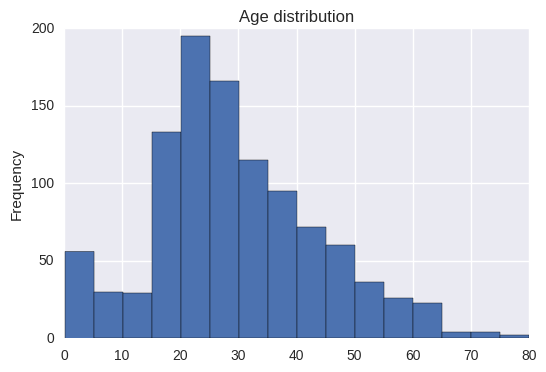

In [8]:
train_test['Age'].plot('hist', bins=16, title = 'Age distribution')

## Cleaning the data

We observe that the age column has missing values.

In [9]:
train_test['Age'].shape[0] - train_test['Age'].count()

263

We fill the missing values by the median age. The same is done for the fare.

In [10]:
train_test['Age'] = train_test['Age'].fillna(train_test['Age'].median())
train_test['Fare'] = train_test['Fare'].fillna(train_test['Fare'].median())

Furthermore, the gender should be encoded to a binary numeric value.

In [11]:
train_test['Sex'] = LabelEncoder().fit_transform(train_test['Sex'])

## Feature Engineering

Feature engineering is the process of generating new features of high predictive potential from the given data. For instance, the family size could be of interest.

In [12]:
train_test['Fam_size'] = train_test['SibSp'] + train_test['Parch']

Furthermore, we add a feature capturing the two-way interaction between age and passenger class.

In [13]:
train_test['Age * Class'] = train_test['Age'] + train_test['Pclass']

## Training of machine-learning classifier

After having completed the feature engineering, a machine-learning classifier can be fitted to the data. We choose a *random-forest model*, an off-the-shelf classifier providing solid performance for many data sets.

In [14]:
rf_clf = RandomForestClassifier(n_estimators = 100)
df_num = train_test[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Fam_size', 'Age * Class']]
rf_clf = rf_clf.fit(df_num.iloc[:train.shape[0], :], train['Survived'])

After fitting to the numeric columns, we can generate predictions on the test set.

In [15]:
predicted = rf_clf.predict(df_num.iloc[train.shape[0]:, :])
predicted_series = pd.Series(predicted, index = df_num.iloc[train.shape[0]:, :].index, name = 'Survived')

Finally, persist the model to disk.

In [16]:
predicted_series.to_csv('./submission.csv', index = True, header = True)